In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc03s
import bfunc

Data load and region parameters

In [3]:
name = 'OrionS'

In [4]:
reg = 'OrionS'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.025

In [7]:
model02 = lmfit.Model(bfunc03s)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.2
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

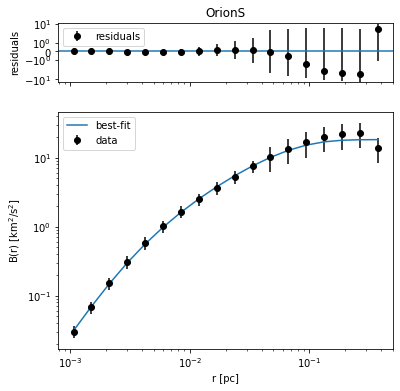

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

#plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc03s)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 93
    # data points      = 18
    # variables        = 5
    chi-square         = 1.51692471
    reduced chi-square = 0.11668652
    Akaike info crit   = -34.5263604
    Bayesian info crit = -30.0745016
##  Warning: uncertainties could not be estimated:
    noise:  at boundary
[[Variables]]
    r0:     0.04054767 (init = 0.04305689)
    sig2:   9.17871445 (init = 9.375507)
    m:      1.13611618 (init = 1.5)
    s0:     0.00164956 (init = 0.001788962)
    noise:  2.5934e-09 (init = 0.1959635)


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(noise=2.3340869237387096e-09) = 0.0 < max(sigmas).
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.01181  -0.00758  -0.00380   0.04055  +0.00437  +0.01037  +0.02169
 sig2 :  -2.21545  -1.36055  -0.65298   9.17871  +0.67964  +1.48555  +2.61186
 m    :  -0.36837  -0.19316  -0.08400   1.13612  +0.07632  +0.15589  +0.24967
 s0   :  -0.00082  -0.00056  -0.00029   0.00165  +0.00039  +0.00102  +0.00248
 noise:      -inf      -inf      -inf   0.00000      +inf      +inf      +inf


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:319: UserWarning: maxiter=200 reached and prob(noise=5.4721371212096415e-08) = 0.0038287168680723404 < max(sigmas).
  warn(errmsg)


In [17]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [18]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [19]:
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result2.params.items():
    print('{:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))

-------------------------------
Parameter    Value       Stderr
r0          0.04055     0.00405
sig2        9.17871     0.91787
m           1.13612     0.11361
s0          0.00165     0.00016
noise       0.00000     0.00000


plt.style.use([
    "seaborn-poster",
])

plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [ ]:
print("--- %s seconds ---" % (time.time()-start_time))